<font color='DarkBlue' size=+2><b>Комментарий ревьюера</b></font><br>
<font color='DarkBlue'>Привет, Марат! <br>Меня зовут Олег Мазуренко, и я буду проверять этот проект. Спасибо за проделанную работу! <br>Ко мне можно обращаться на «ты». Как мне обращаться, напиши.</font><br>
<font color='DarkBlue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font><br>
<font color='DarkBlue'>Синий текст &mdash; просто текст комментария.</font><br>
<font color='DarkGreen'>👌 Зеленый текст &mdash; все отлично.</font><br>
<font color='DarkMagenta'>👉 Фиолетовый текст &mdash; сделано все правильно, однако есть рекомендации, на что стоит обратить внимание. Реализованные рекомендации позволят нам наработать опыт решения задачи разными способами или посмотреть на задачу под иным углом.</font><br>
<font color='Red'>🛠 Красный текст &mdash; есть недочеты, они иногда бывают. </font><br><font color='DarkBlue'>Любая ошибка это возможность посмотреть на задачу с другой стороны и освоить новые знания, по этому не надо расстраиваться, если они есть.</font><br>
<font color='DarkBlue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты и сразу увидеть исправленное. <br>
Ответы на мои комментарии лучше тоже помечать. 
Например: </font><font color='Blue'><b>Комментарий студента</b></font><br>
<font color='DarkBlue'><b>Теперь посмотрим, что у нас получилось!</b></font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Привет, Олег! Приятно познакомиться)
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Привет! Хорошо, пошел смотреть, что мы наработали.</font>

# Исследование закономерностей успешности игр

**Цель исследования**: На основе собранных данных по различным играм и платформам за определенный период нам нужно выявить успешность тех или иных продуктов на рынке игр по всему миру и проверить полученные гипотезы, чтобы узнать приоритетные для закупки игры в следующем году.

**Ход исследования**:
- предобработать данные (работа с пропусками, дубликатами, типами и пр.)
- добавить столбцы предварительного расчета, если это будет необходимо
- провести исследовательский анализ данных по разным параметрам
- выяснить типичный портрет покупателя игр в разных регионах
- сформулировать и проверить гипотезы
- подвести итоги

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, сделали описание проекта. 👍</font>

## Предобработка данных

### Получение данных. Первичное знакомство

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None 
sns.set(rc={'figure.figsize':(10,5)})
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
try:
    initial_data = pd.read_csv('/datasets/games.csv')
except:
    raise Exception('Something is wrong. Check the file')

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Лучше разделять по разным ячейкам загрузку библиотек и датасета.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Разбил.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌  Входе работы иногда приходится дополнительно загружать другие библиотеки, их вставляем в первую ячейку и перезагружаем. Так как датасет грузится отдельно, то можем продолжить работу с таблицей, которую уже обработали и преобразовали. А если у нас все в одном флаконе, то придется перезагружать всю тетрадку. При очень больших датасетах это может быть длительной процедурой. </font>

In [3]:
# взглянем на первичные данные
initial_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные на месте, но уже бросаются в глаза пропуски, неправильная запись годов и пр. Займемся этим последовательно.

In [5]:
# работать будем с новым датафреймом на тот случай, если нам в будущем потребуются исходные данные до всех манипуляций
data = initial_data.copy()

### Названия столбцов

Приведем названия столбцов к классическому нижнему регистру.

In [6]:
data = data.rename(columns={'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 
                            'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 
                            'Other_sales': 'other_sales','Critic_Score': 'critic_score', 'User_Score': 'user_score', 
                            'Rating': 'rating'})
data.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо! Приводим названия колонок к общепринятому стилю. 😉 <br>
А можно просто методом вот так:</font><br>
`df.columns = df.columns.str.lower()`

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Запомню.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Короткий код - показатель профессионализма. Мы профи! Или как? 😄</font>

### Работа с пропусками

In [7]:
#кол-во явных пропусков в данных
data.isna().sum().sort_values(ascending=False)

critic_score       8578
rating             6766
user_score         6701
year_of_release     269
name                  2
genre                 2
platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
dtype: int64

In [8]:
# процент пропусков от общего числа
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Как мы видим, больше всего пропусков в оценках критиков. Возможно, больше 50% игр из списка вышли до того, как мнение критиков стало централизованно собираться. При этом много пропусков и у пользовательских оценок и рейтинга ESRB. А вот доля пропусков в названиях, жанрах и годах выпуска ничтожна, поэтому от этих пропусков можно будет избавиться.

In [9]:
# избавляемся от части пропусков
data = data.dropna(subset=['name', 'year_of_release', 'genre'])

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что удалили пропуски, тем более в этих строках еще хватает пропусков по другим колонкам.</font>

Просто удалить пропуски в оценках и рейтингах нельзя, их слишком много. Равно как и заполнить средними или медианными значениями для количественных данных. Игры — продукт очень разноплановый, там просто нет никаких объективных стандартов, не говоря уже о субъективном мнении людей. Нередки случаи, когда игра получает высокие оценки от критиков и очень низкие от игроков и наоборот. Попытка усреднить оценки для всех игр может сильно сказаться на итогах исследования, поэтому будет лучше заполнить пропуски отдельными категориями. При дальнейшем анализе будем это помнить и при необходимости изменим. Есть вероятность, что эти данные даже не пригодятся.

In [10]:
data['critic_score'] = data['critic_score'].fillna('Нет оценки')
data['user_score'] = data['user_score'].fillna('Нет оценки')
data['rating'] = data['rating'].fillna('Нет рейтинга')

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Зачем мы в ячейки отзывов с числовыми данными вставляем в символьную заглушку?</font><br>
<font color='DarkMagenta'>👉 Правильно поставлена заглушка на пропуски в колонке рейтинга. А если посмотреть в интернете, что такое рейтинг ESRB, то мы узнаем, что это рейтинг для США и Канады. А значит пропуск не савязан с ошибкой заполнения данных, просто не только для Северной Америки выпускаются игры.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Поставил, чтобы не оставлять пропуски, а потом легко отделить от общей кучи. А если поставить какое-то число, то потом спутается с другими.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 В чем разница, оставлять NaN или ставить заглушку:<br>
- NaN нам не мешают при построении графиков и расчете корреляции, но искажает расчет в тесте Стьюдента мы получим NaN. А так как пропуск не везде мешает, то мы можем забыть его отфильтровать и получить не верный результат. В отдельных случаях наличие пропуска в датасете не связано с низким качеством сбора данных датасета, а может являтся значимым признаком, но если мы пропуск не заменим на заглушку, то мы этого даже не заметим. Пример в нашем проекте - хитрый рейтинг ESRB.
- Заглушка нам везде мешает, по этому мы при анализе целевого параметра, который в датасете содержал NaN, мы всегда отфильтровываем ее. Заглушку лучше ставить далеко вне диапазона целевых параметров. Если мы вдруг забудем ее отфильтровать, то сразу заметим при преобразованиях. Кроме того, заглушка показывает, что мы оценили количество пропусков в датасете и приняли по ним обоснованное решение. Но мы можем сделать анализ и с учетом заглушки и обнаружить неявный признак который нес пропуск. Что мы и сделали в этом проекте.</font>

<font color='DarkBlue'><b>Комментарий ревьюера: Глоссарий</b></font><br>
<font color='DarkGreen'>👌 В контексте анализа и предобработки датасета часто используютется термин: <b>Заглушка</b>. <br>Из словаря: "Заглушка — приспособление для закрывания отверстия наглухо." <br>В нашем контексте закрытие пропуска в датасете каким-то значением, совпадающим по типу с данными колонки таблицы. Как правило, для числовых данных заглушка должна быть вне диапазона значений колонки. При анализе по данной колонке заглушка или фильтруется, или включается в анализ, если сам пропуск не является ошибкой сбора данных и несет какой-то признак. <br>Частая ошибка, когда заглушке присваивается числовое значение, например `0`, а в данных колонки присутствуют значения `'0'`, то при преобразовании к числовому типу произойдет слияние значимых данных таблицы и заглушки.</font>

In [11]:
data.isna().sum().sort_values(ascending=False)

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Работа с типами

In [12]:
# исправим года релизов игр на int, более тонкая работа именно как с датами вряд ли понадобится ввиду наличия только года
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['year_of_release'].head()

0    2006
1    1985
2    2008
3    2009
4    1996
Name: year_of_release, dtype: Int64

In [13]:
# посмотрим, действительно ли требуется float для оценок критиков и игроков
# pd.set_option('display.max_rows', None)
data['critic_score'].value_counts()

Нет оценки    8461
70.0           252
71.0           248
75.0           240
80.0           235
              ... 
20.0             3
29.0             3
17.0             1
21.0             1
13.0             1
Name: critic_score, Length: 82, dtype: int64

In [14]:
data['user_score'].value_counts()

Нет оценки    6605
tbd           2376
7.8            322
8              285
8.2            276
              ... 
1.1              2
0.7              2
1.5              2
9.7              1
0                1
Name: user_score, Length: 97, dtype: int64

Видим, что критики использовали целочисленную шкалу до 100, а игроки могли выставить оценку с дробной частью. Приведем к Int оценки критиков.

In [15]:
data.loc[data['critic_score'] != 'Нет оценки', 'critic_score'] = \
data.loc[data['critic_score'] != 'Нет оценки', 'critic_score'].astype('int')

Кол-во миллионов проданных копий округлять надобности нет, как и менять типы object категориальных значений. Однако на глаза попадается странное значение *tbd* в оценках пользователей. Это явный пропуск значения, который был упущен на предыдущем этапе. Скорее всего значит, что решение по оценке ожидается. Для нас это просто пропуск, которому мы назначим ту же группу, что и другим пропускам.

In [16]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 'Нет оценки'

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно сделана замена "tbd". Это практически аналог пропусков.</font>

### Общие продажи каждой игры
Добавим новый столбец *total_sales*, куда поместим общее число проданных копий каждой игры во всех регионах.

In [17]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,Нет оценки,Нет оценки,Нет рейтинга,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,Нет оценки,Нет оценки,Нет рейтинга,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,Нет оценки,Нет оценки,Нет рейтинга,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,Нет оценки,Нет оценки,Нет рейтинга,28.31


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Мы молодцы, не забыли создать колонку с общими продажами. 👍 <br> А можно использовать вот такой код:</font><br>
` = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)`

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Запомню.
</div>

### Работа с дубликатами

In [18]:
# проверяем наличие явных дубликатов
data.duplicated().sum()

0

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что проверены дубликаты, иногда они сильно искажают анализ.</font>

In [19]:
# проверяем неявные дубликаты в названии жанров
data['genre'].value_counts()

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64

In [20]:
# проверяем неявные дубликаты в названии платформ
data['platform'].value_counts()

PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

Проверить дубликаты в названии игр в данный момент не получится, их слишком много для ручной проверки.

In [21]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  object 
 9   user_score       16444 non-null  object 
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(5), object(6)
memory usage: 1.6+ MB
None
-------------------------
name ['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
name : ко

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 А почему данные колонки отзывов пользователей не приведены к числовому типу?</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Вероятно, пропустил на тот момент, но потом все же менял.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Проект все равно делаем в несколько итераций, если в предобработке что-то не сделали, то потом возвращаемся к началу и корректируем. Это обычная практика.</font>

## Исследовательский анализ данных

### Поиск полезных данных
Проверим динамику выпуска игр и выберем лучший для анализа период.

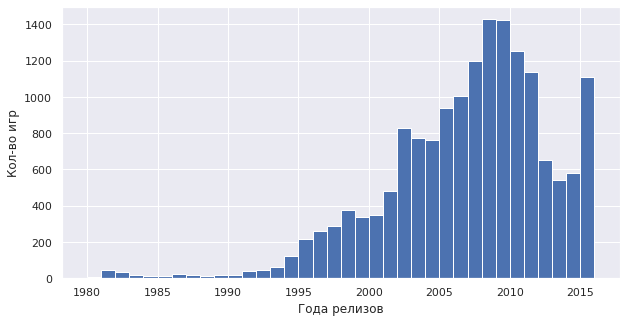

In [22]:
games_years = data['year_of_release'].hist(bins=36)
games_years.set_xlabel("Года релизов")
games_years.set_ylabel("Кол-во игр");

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Для того что бы гистограмма отражала выпуск игр по годам надо подобрать параметр `bins` равный количеству лет релиза в нашем датасете. Тогда у нас не будет пиков на графике. </font><br>
<font color='DarkMagenta'>👉 Визуализация подразумевает подписи осей, название графика, при необходимости наличие меток. </font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Дополнил.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 А гистограмма не корректна. Вот так правильно:</font>

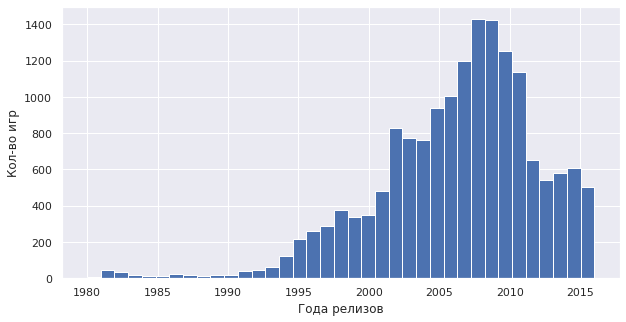

In [23]:
# Комментарий ревьюера 2
games_years = data['year_of_release'].hist(bins=37)
games_years.set_xlabel("Года релизов")
games_years.set_ylabel("Кол-во игр");

Видим, что в датасете присутствуют игры с 1980 года, но настолько старые игры сейчас будут мало интересны. Геймдев с тех пор сильно изменился, как и рынок развлечений, поэтому для анализа придется брать не все данные. Первый внушительный пик с постоянным ростом пришелся на 2004, его и можно будет считать границей.

In [24]:
# сколько было продано копий всех игр в зависимости от платформы
data.groupby('platform')['total_sales'].sum().sort_values()

platform
PCFX       0.03
GG         0.04
3DO        0.10
TG16       0.16
WS         1.42
NG         1.44
SCD        1.86
DC        15.95
GEN       28.35
SAT       33.59
PSV       53.81
WiiU      82.19
2600      86.48
XOne     159.32
GC       196.73
SNES     200.04
N64      218.01
NES      251.05
XB       251.57
GB       254.43
PC       255.76
3DS      257.81
PSP      289.53
GBA      312.88
PS4      314.14
PS       727.58
DS       802.78
Wii      891.18
PS3      931.34
X360     961.24
PS2     1233.56
Name: total_sales, dtype: float64

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 При анализе принято визуализировать результаты в виде графиков или диаграмм. Таблицы малоинформативны и не наглядны.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Учту.
</div>

In [25]:
# в разбивке по годам и платформам
#pd.set_option('display.max_columns', None)
data.pivot_table(index='platform', columns='year_of_release', values='name', aggfunc='count')

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
2600,9.0,46.0,36.0,11.0,1.0,1.0,2.0,6.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,116.0,93.0,91.0,80.0,86.0,46.0
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,376.0,492.0,403.0,323.0,153.0,23.0,8.0,NaN,NaN,NaN
GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В списке много платформ, на которые игры больше не делают, поэтому для дальнейшего анализа от них нужно будет избавиться. 

Итого:
1. Нужно убрать игры ранее 2004 года выпуска
2. Нужно будет оставить из них те, кто скорее всего будут выпускаться в 2017 году на платформах (PC, XOne, PS4, PS3, WiiU, 3DS, X360).

Следовательно, для единообразия будем рассматривать период 2014-2016 гг, как период, когда существовали все платформы из списка. При этом для части анализа будем использовать только PC, XOne, PS4 как самые многообещающие. PS3 и X360 — уходящее поколение. То же относится к WiiU и 3DS с учетом анонса Nintendo Switch. В среднем многие платформы живут 5-10 лет, поэтому для всего анализа рассматривать все платформы не имеет смысла. Только PC будет нарушать картину, так как используется не только для игр.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно выбран актуальный период. 👍 Сейчас в наше динамичное время в бизнесе уже используются для прогноза периоды в 2-3 года.</font><br>
<font color='Red'>🛠 В задании необходимо отфильтровать данные по актуальному периоду, но мы еще фильтруем по платформам. Тем самым теряем часть данных, которые нам понадобятся для анализа жанров, возрастного рейтинга, продаж по регионам. Последние не зависят от платформы, являются свойствами конкретной игры, а не свойством платформы.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Оставил только актуальные данные по годам.
</div>

In [26]:
actual_data = data.query('year_of_release > 2013')

Датасет сократился, так как по большей части был собран из неактуальных данных по годам или платформам. Игровая индустрия бурно развивается, поэтому для анализа имеет смысл брать только всё самое свежее.

### Сравнение актуальных платформ

<AxesSubplot:xlabel='platform'>

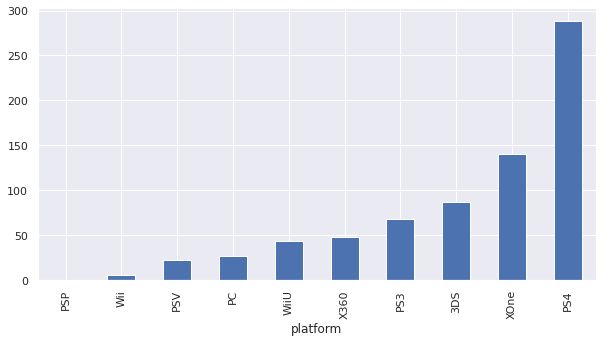

In [27]:
# посмотрим, кто лидирует по продажам среди платформ
actual_data.groupby('platform')['total_sales'].sum().sort_values().plot(kind='bar')

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Правильно было бы отсортировать платформы по продажам.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Отсортировал.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Хорошо, теперь правильно. 👍</font>

<AxesSubplot:xlabel='year_of_release'>

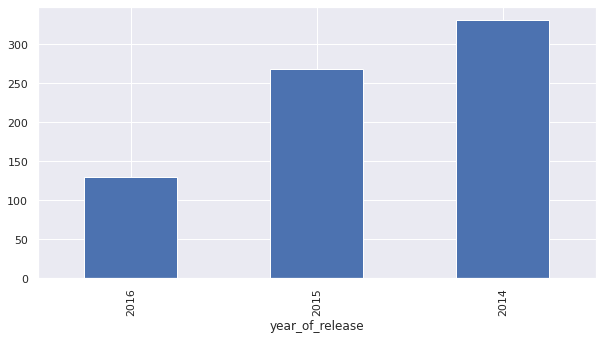

In [28]:
actual_data.groupby('year_of_release')['total_sales'].sum().sort_values().plot(kind='bar')

PS4 держит уверенное лидерство по количеству проданных копий, при том, что XOne вышел в то же время, а PC существует уже давно. Посмотрим на динамику 2014-2016 года.

<AxesSubplot:xlabel='year_of_release'>

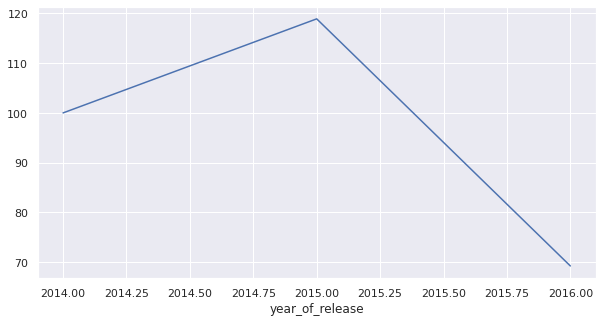

In [29]:
# динамика PS4 по кол-ву проданных копий всех игр
(
    actual_data.query('platform == "PS4"')
    .groupby('year_of_release')['total_sales'].sum()
    .plot(grid=True, figsize=(10,5))
)

<AxesSubplot:xlabel='year_of_release'>

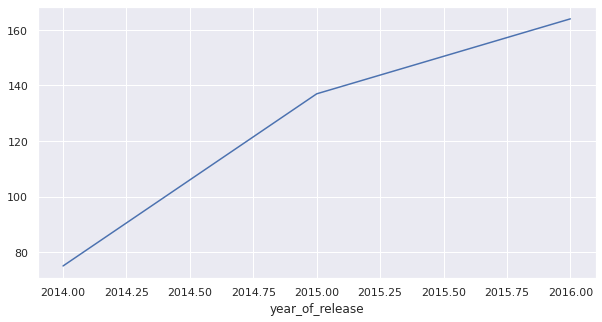

In [30]:
# динамика PS4 по кол-ву новых проектов
(
    actual_data.query('platform == "PS4"')
    .groupby('year_of_release')['name'].count()
    .plot(grid=True, figsize=(10,5))
)

Видим, что с момента старта консоль показывала рост продаж игр для себя, но с начала 2015 года пошел резкий спад, хотя кол-во новых проектов постоянно растет и наверняка будет продолжать это делать, пока не выйдет следующее поколение. Спад может быть вызыван развитием двух других платформ. Давайте посмотрим.

<AxesSubplot:xlabel='year_of_release'>

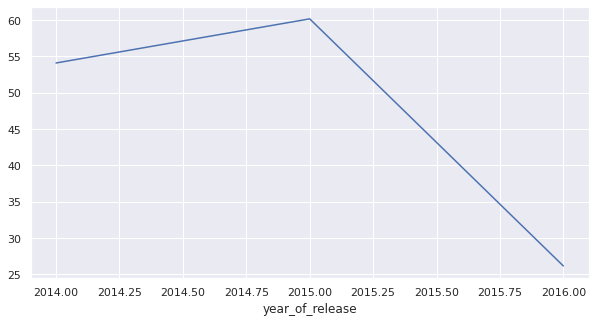

In [31]:
# динамика XOne по кол-ву проданных копий всех игр
(
    actual_data.query('platform == "XOne"')
    .groupby('year_of_release')['total_sales'].sum()
    .plot(grid=True, figsize=(10,5))
)

<AxesSubplot:xlabel='year_of_release'>

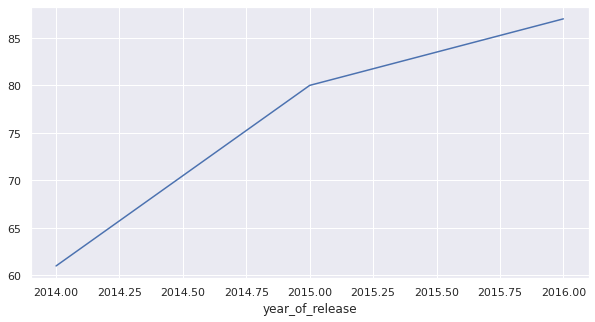

In [32]:
# динамика XOne по кол-ву новых проектов
(
    actual_data.query('platform == "XOne"')
    .groupby('year_of_release')['name'].count()
    .plot(grid=True, figsize=(10,5))
)

<AxesSubplot:xlabel='year_of_release'>

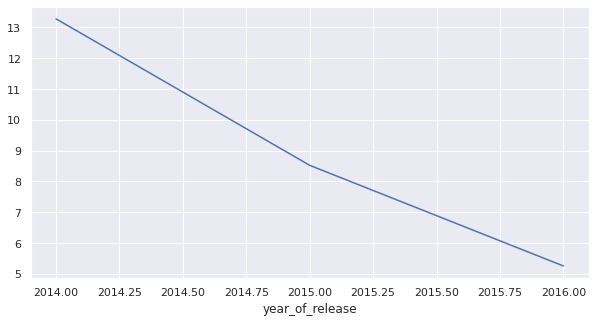

In [33]:
# динамика PC по кол-ву проданных копий всех игр
(
    actual_data.query('platform == "PC" and year_of_release > 2013')
    .groupby('year_of_release')['total_sales'].sum()
    .plot(figsize=(10,5), grid=True)
)

<AxesSubplot:xlabel='year_of_release'>

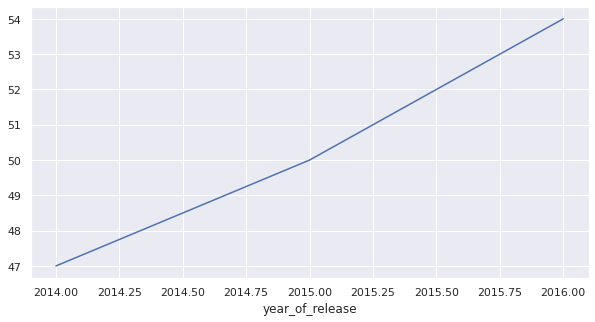

In [34]:
# динамика PC по кол-ву новых проектов
(
    actual_data.query('platform == "PC" and year_of_release > 2013')
    .groupby('year_of_release')['name'].count()
    .plot(figsize=(10,5), grid=True)
)

В итоге мы видим, что кол-во продаж проседает у всех платформ после 2015 года, а на ПК спад постоянен, что может быть вызвано разными причинами, например, легкостью пиратства. При этом количество выпускаемых игр только растет. Посмотрим также на боксплоты по платформам.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Почему мы строим диаграммы размаха не по всем платформам? В задании топ-платформы не требуются, предполагаются все. Мы таким образом теряем значимую информацию. И диаграммы размаха надо строить на одной координатной сетке (у нас же сравнительный анализ) в двух видах, в полном, со всеми выбросами и масштабированном с крупными боксплотами. Для вывода только нижней части boxplot-ов необходимо использовать параметр ylim. </font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Изменил.
</div>

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

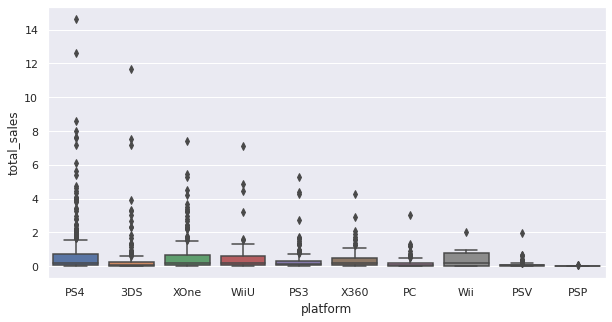

In [35]:
# диаграммы размаха полные для платформ
sns.boxplot(x='platform', y='total_sales', data=actual_data)

(0.0, 1.55)

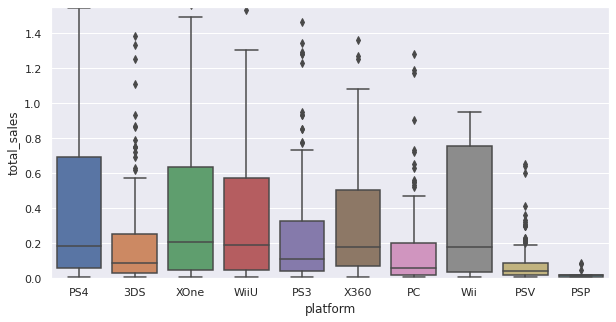

In [36]:
# нижние границы диаграмм размаха
sns.boxplot(x='platform', y='total_sales', data=actual_data)
plt.ylim(0, 1.55)

(0.0, 0.76)

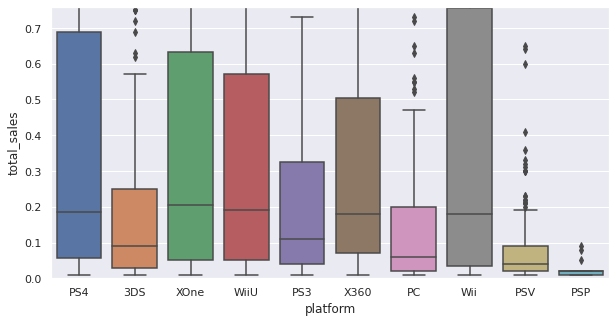

In [37]:
sns.boxplot(x='platform', y='total_sales', data=actual_data)
plt.ylim(0, 0.76)

Из сравнительного анализа можно сделать выводы:
- PS4 имеет больше всего выбросов, что может говорить об очень успешных продуктах, которые имеет смысл приобретать, если новые игры будут частью успешных серий
- Медианные же значения у PS4, XOne, WiiU, X360, Wii находятся примерно на одном уровне (190 тыс. копий)
- При этом платформы из пункта выше имеют и куда больший размах, чем остальные

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Для интерпретации диаграмм размаха помогает вспомнить, что означают боксплоты:</font>
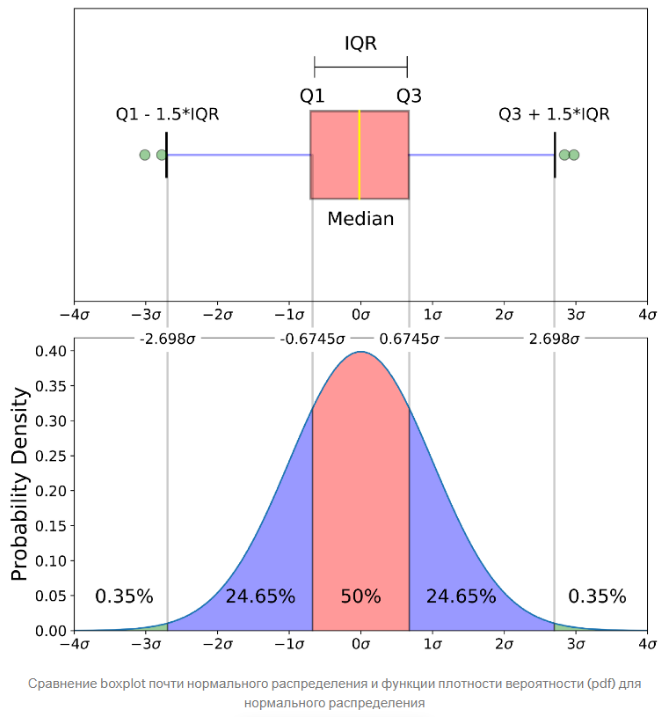

### Влияние оценок и отзывов на продажи
Посмотрим для трех актуальных платформ влияние оценок критиков и пользователей.

In [38]:
# уберем в отдельный датафрейм игры без оценок, нам понадобятся только они
actual_data_copy = actual_data.copy()
data_with_critic_scores = actual_data_copy.loc[actual_data_copy['critic_score'] != "Нет оценки"]
data_with_user_scores = actual_data_copy.loc[actual_data_copy['user_score'] != "Нет оценки"]

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Как-то мы оптом отфильтровываем заглушки. Если мы анализируем отзывы пользователей, то фильтруем заглушки по ним. Если анализируем отзывы критиков, то фильтруем эти заглушки. А вот удаление одновременно и тех и других ведет к необоснованному удалению данных и искажению расчета корреляции. См.код ниже.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Сделал отдельно для критиков и игроков.
</div>

In [39]:
# Комментарий ревьюера
print(len(actual_data_copy.loc[actual_data_copy['user_score'] != "Нет оценки"]))
print(len(actual_data_copy.loc[actual_data_copy['critic_score'] != "Нет оценки"]))
print(len(actual_data_copy.loc[(actual_data_copy['critic_score'] != "Нет оценки") & (actual_data_copy['user_score'] != "Нет оценки")]))

888
718
704


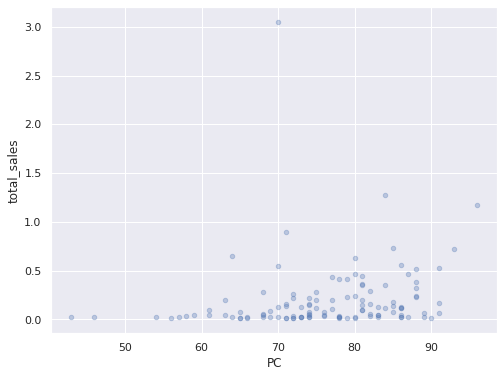

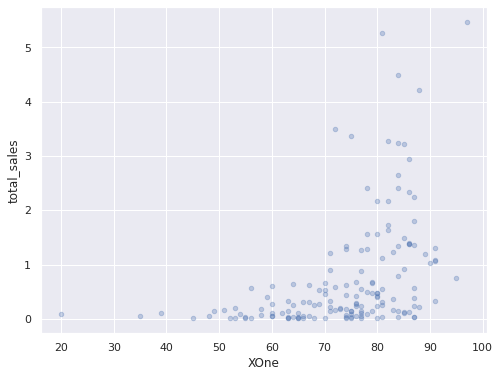

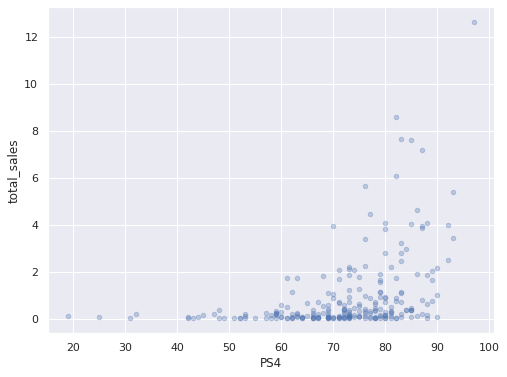

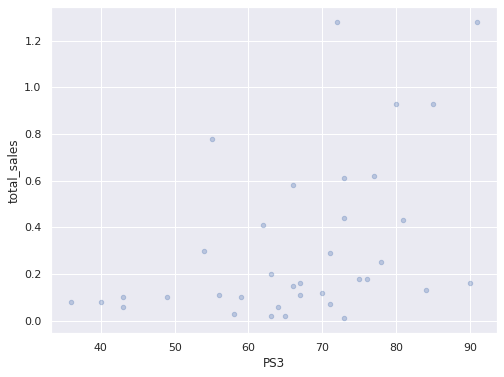

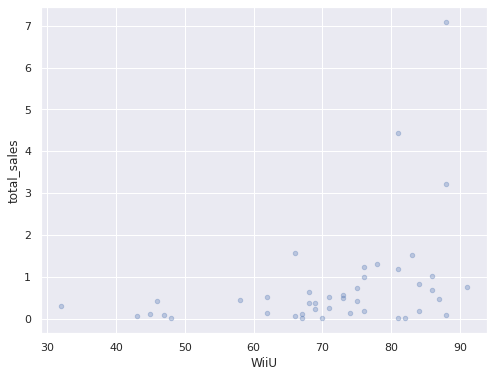

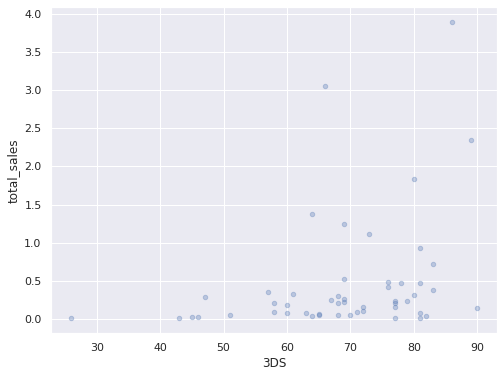

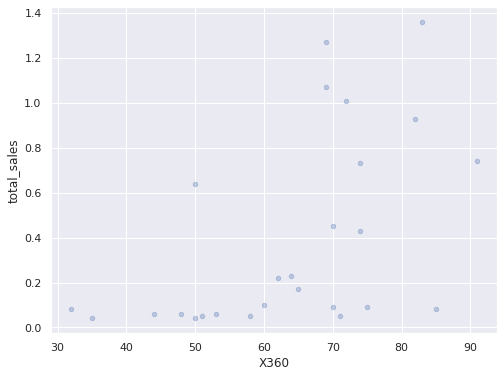

In [40]:
platforms = ['PC', 'XOne', 'PS4', 'PS3', 'WiiU', '3DS', 'X360']

# построим диаграммы рассеяния для оценок критиков
for platform in platforms:
    (data_with_critic_scores
         .query('platform == @platform')
         .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(8, 6), legend=True)
         .set_xlabel(platform)
    );
   

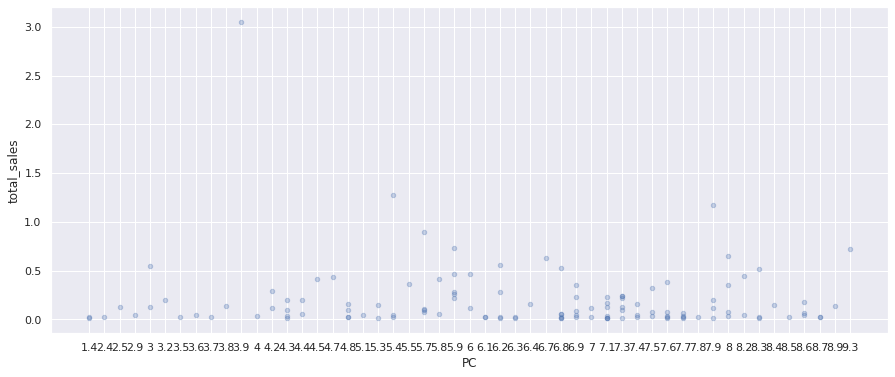

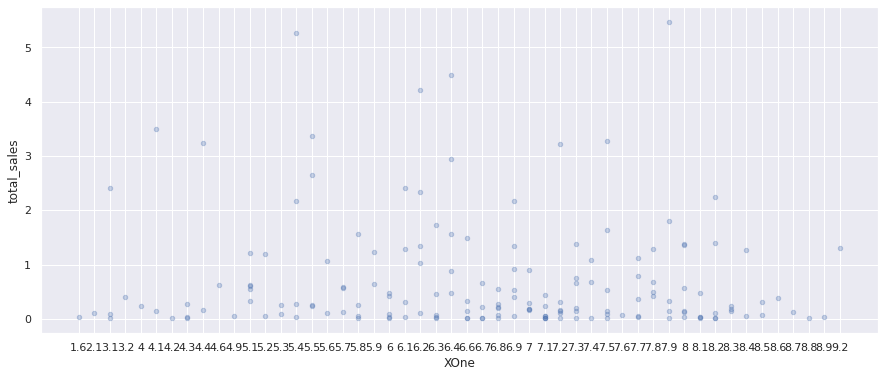

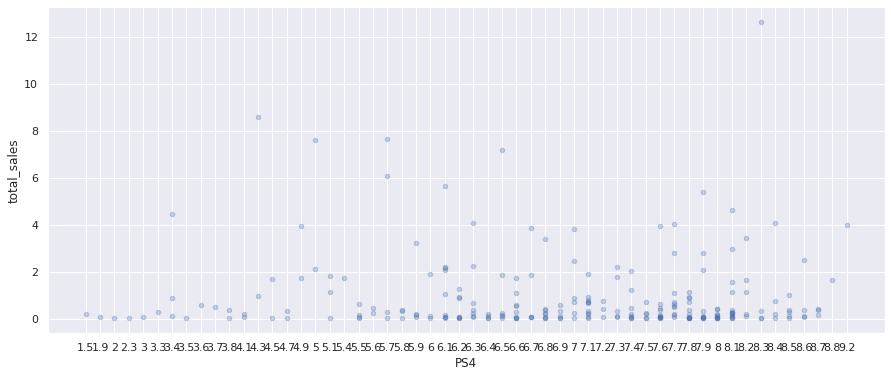

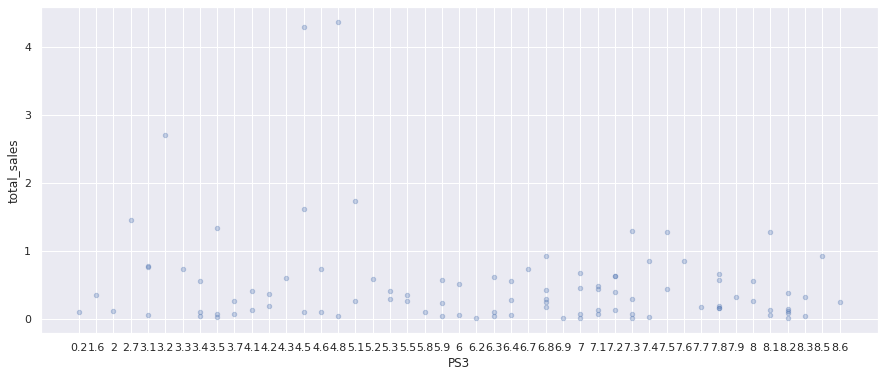

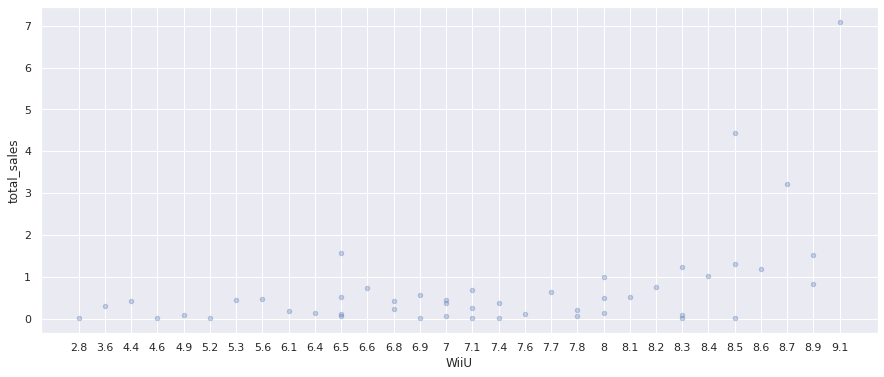

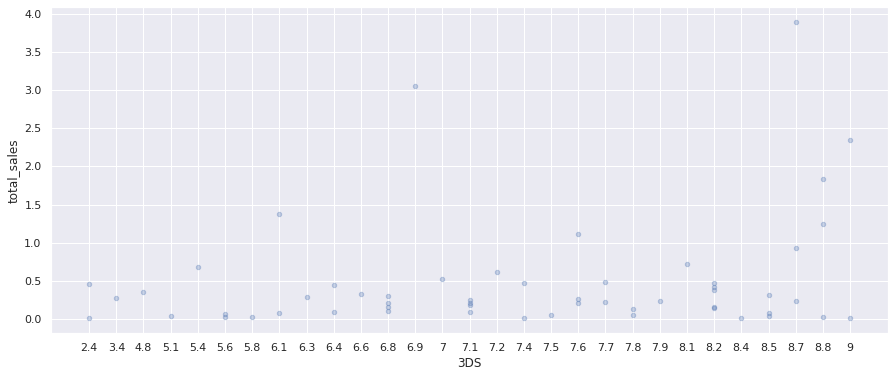

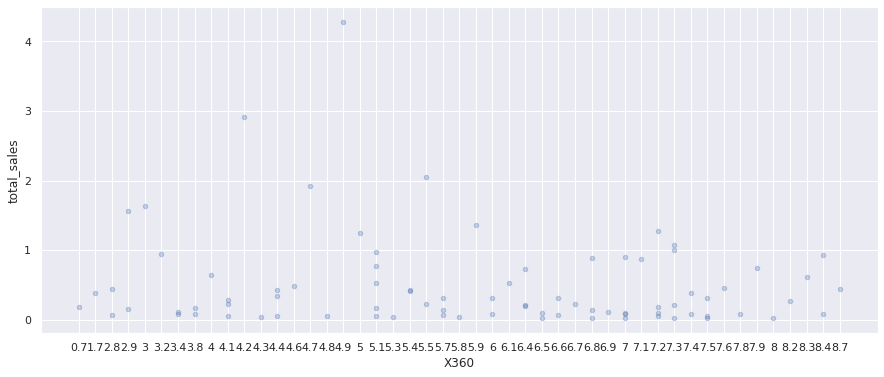

In [41]:
# построим диаграммы рассеяния для оценок игроков
for platform in platforms:
    (data_with_user_scores
        .query('platform == @platform')
        .sort_values('user_score')
        .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(15, 6))
        .set_xlabel(platform)
    );

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Это мы строим диаграмму размаха по строковым, а не числовым данным?</font>

In [42]:
# Комментарий ревьюера 2 
data_with_user_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 42 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             888 non-null    object 
 1   platform         888 non-null    object 
 2   year_of_release  888 non-null    Int64  
 3   genre            888 non-null    object 
 4   na_sales         888 non-null    float64
 5   eu_sales         888 non-null    float64
 6   jp_sales         888 non-null    float64
 7   other_sales      888 non-null    float64
 8   critic_score     888 non-null    object 
 9   user_score       888 non-null    object 
 10  rating           888 non-null    object 
 11  total_sales      888 non-null    float64
dtypes: Int64(1), float64(5), object(6)
memory usage: 91.1+ KB


Видим, что если говорить об отзывах критиков, то заметен рост продаж с повышением оценок. У каких-то платформ хорошо виден, у других — не очень. Может быть связано с неравномерностью кол-ва оцененных игр. С оценками игроков не все так однозначно. Явного роста нет, даже низкооцененные игры могут хорошо продаться. Это может быть связанно с тем, что маркетинговая составляющая отдельных продуктов отличная, что обеспечивает высокие стартовые продажи, но по факту игра может не понравиться большинству пользователей. Посмотрим на корреляции.

In [43]:
# изменим тип данных на числовые для вычисления корреляции
data_with_critic_scores['critic_score'] = data_with_critic_scores['critic_score'].astype('int')
data_with_user_scores['user_score'] = data_with_user_scores['user_score'].astype('float')

# посчитаем корреляцию между продажами и оценками критиков для основных платформ
for platform in platforms:
    print(platform, 
          data_with_critic_scores.query('platform == @platform')['total_sales'].corr(data_with_critic_scores['critic_score'])
         )

PC 0.17463413769350036
XOne 0.42867694370333226
PS4 0.40266141068104083
PS3 0.44657460493190704
WiiU 0.370201412480884
3DS 0.31411749286905105
X360 0.5257228356581523


Как мы видим, есть слабая положительная корреляция у консолей. Взглянем по оценкам игроков.

In [44]:
for platform in platforms:
    print(platform, 
          data_with_user_scores.query('platform == @platform')['total_sales'].corr(data_with_user_scores['user_score'])
         )

PC -0.07159665703472452
XOne -0.0703839280647581
PS4 -0.040131589472697356
PS3 -0.16676141347662116
WiiU 0.4079264579217078
3DS 0.2151932718527028
X360 -0.138444570945665


Между оценками игроков и продажами явной корреляции не видно, хотя X360 подобрался к границе слабой положительной.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 В задании написано: <b>Соотнесите выводы с продажами игр на других платформах.</b> А мы сравнили только три. Выводы, сделанные на основе диаграмм рассеяния и расчетов по нескольким платформам выглядят "весомей" и убедительней. Все платформы не надо, но хотя бы штук пять. Построение диаграмм рассеяния и расчет корреляции можно сделать циклом.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Изменил. Взял почти все платформы за актуальный период.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Для оценки корреляции лучше пользоваться вот этой шкалой:</font>
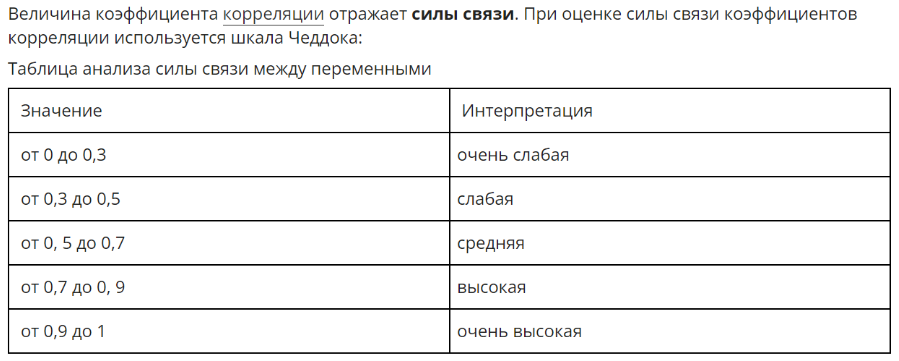

### Влияние жанров на продажи

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Вот тут мы делаем ошибку, так как используем таблицу не за весь актуальный период, а отфильтрованную  по платформам. Но жанр является свойством игры, а не платформы. В итоге мы таким образом отфильтровали более 3% объема продаж. См.код ниже.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Теперь присутствуют все платформы.
</div>

In [45]:
# Комментарий ревьюера
temp1, temp2 = actual_data.total_sales.sum(), data.query('year_of_release > 2013').total_sales.sum()
temp1, temp2, round((temp2-temp1)/temp2*100, 2)

(729.45, 729.45, 0.0)

<AxesSubplot:>

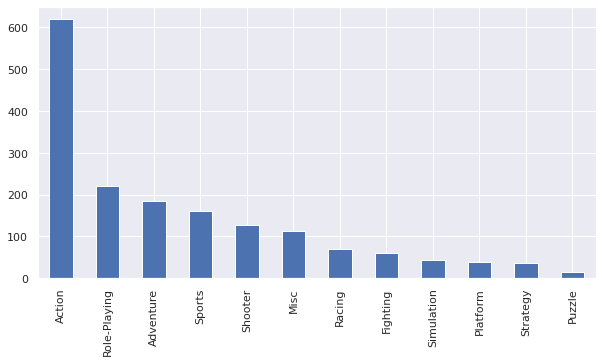

In [46]:
# посмотрим на общую картину по жанрам игр
actual_data['genre'].value_counts().plot(kind='bar')

Больше всего игр среди трех лидирующих платформ в жанре *action*. Далее идут шутеры, спортивные и ролевые игры. Посмотрим на общее кол-во продаж для жанров.

<AxesSubplot:xlabel='genre'>

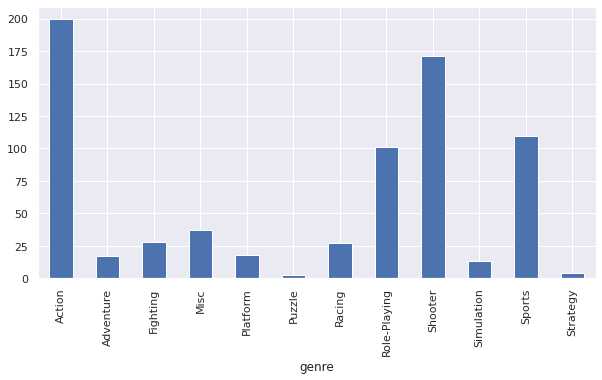

In [47]:
actual_data.groupby('genre')['total_sales'].sum().plot(kind='bar')

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Мы здесь попали в ловушку, что максимальные продажи являются самыми прибыльными. Но у нас в данных продажи по жанру для разных платформ, и если одна платформа со своей одной игрой в данном жанре выстрелила, а остальные провалились, то мы все равно будем видеть максимум общих продаж, даже если остальные платформы провалились. Но для прибыльности нам нужен стабильные жанры, который приносит доход не зависимо от платформы, значит на этот жанр есть устойчивый спрос.</font><br>
<font color='Red'>🛠 По этому нам лучше добавить сравнение медианных продаж, проиллюстрировав их диаграммами размаха и изменить промежуточные выводы.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Добавил сравнение медианных продаж.
</div>

<AxesSubplot:xlabel='genre'>

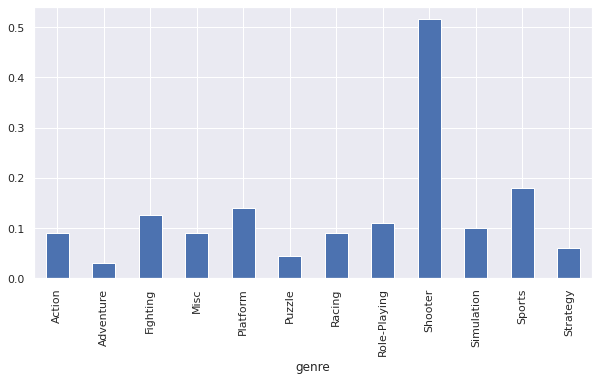

In [48]:
actual_data.groupby('genre')['total_sales'].median().plot(kind='bar')

(0.0, 1.0)

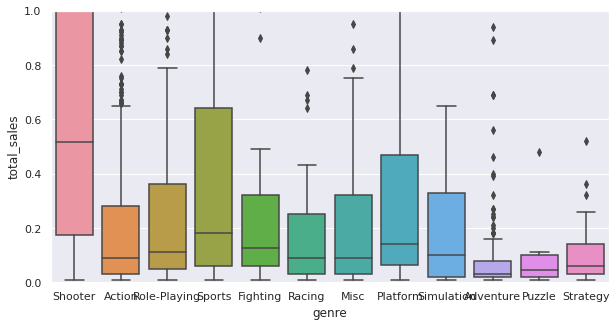

In [49]:
sns.boxplot(x='genre', y='total_sales', data=actual_data)
plt.ylim(0,1)

Несмотря на то, что экшн-игр выходило намного больше, по кол-ву продаж шутеры почти догнали экшены, а потом идут спортивные и ролевые игры. Однако, медианные показатели говорят нам, что жанр шутеров является более прибыльным, следовательно более предпочительный для нас. Взглянем в разрезе отдельных платформ.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 В проекте под "прибыльностью" понимается наличие устойчивого спроса пользователей на данный жанр. Можно сделать уникальный сюжет, быстрый движок, красивую графику и вложить немеряно денег в рекламу и продажи игры подпрыгнут. Но нам лучше выбирать игру из жанра, на которой есть постоянный спрос независимо от маркетинговых усилий производителей игр.<br>
Это хороший пример, когда на одних и тех же данных разные диаграммы дают разный анализ. Визуализация это не только красивое представление табличных данных, а еще и инструмент анализа.</font>

<AxesSubplot:xlabel='genre'>

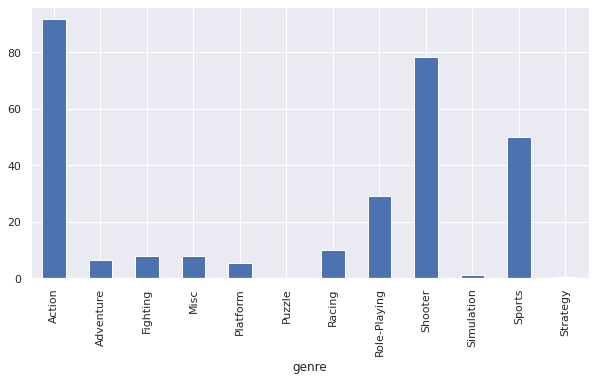

In [50]:
# PS4
actual_data.query('platform == "PS4"').groupby('genre')['total_sales'].sum().plot(kind='bar')

(0.0, 2.0)

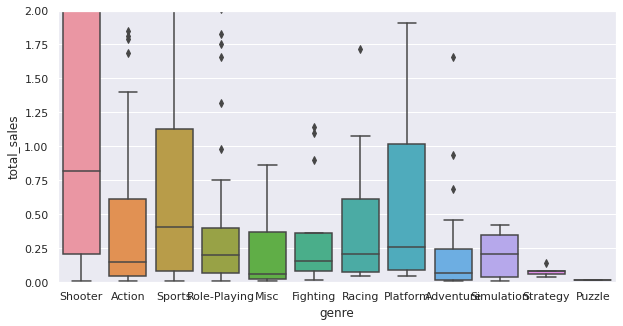

In [51]:
sns.boxplot(x='genre', y='total_sales', data=actual_data.query('platform == "PS4"'))
plt.ylim(0,2)

На PS4 по медианным продажам преобладают шутеры, а потом спортивные игры, а суммарно больше всего продано игр в жанре экшен, что может указывать на отдельные хиты.

<AxesSubplot:xlabel='genre'>

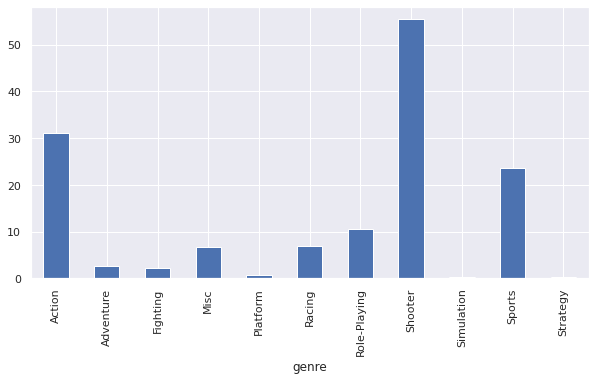

In [52]:
# XOne
actual_data.query('platform == "XOne"').groupby('genre')['total_sales'].sum().plot(kind='bar')

(0.0, 2.0)

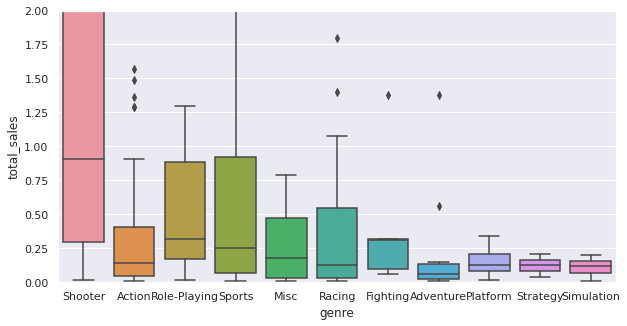

In [53]:
sns.boxplot(x='genre', y='total_sales', data=actual_data.query('platform == "XOne"'))
plt.ylim(0,2)

У XOne медианные продажи лидируют также у шутеров, а потом у ролевых игр. Шутеров и в целом было продано больше всего.

<AxesSubplot:xlabel='genre'>

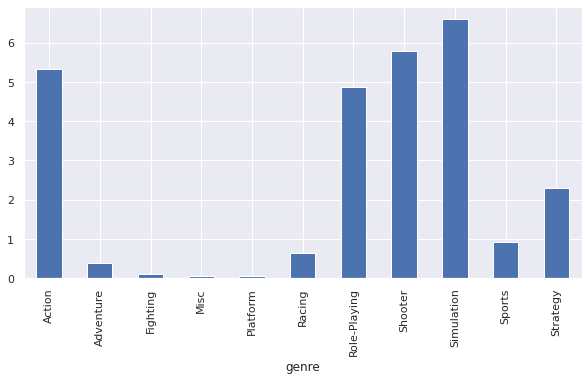

In [54]:
# PC
actual_data.query('platform == "PC"').groupby('genre')['total_sales'].sum().plot(kind='bar')

(0.0, 1.0)

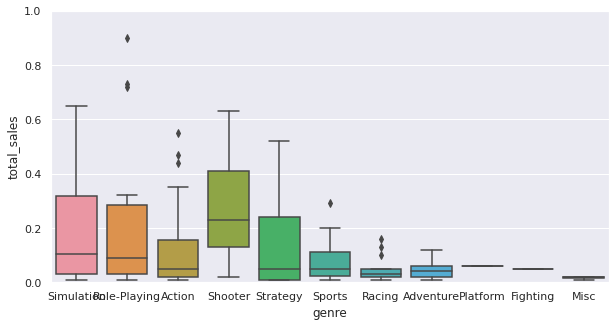

In [55]:
sns.boxplot(x='genre', y='total_sales', data=actual_data.query('platform == "PC"'))
plt.ylim(0,1)

На PC тоже лидируют шутеры, а за ними симуляторы и ролевые игры по медианным продажам, а по общему количеству выстреливают симуляторы, экшен и шутеры.

<AxesSubplot:xlabel='genre'>

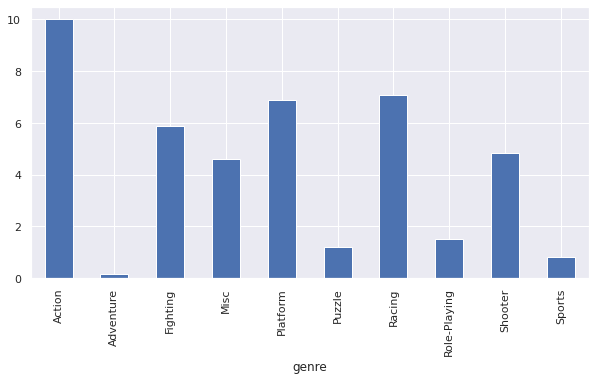

In [56]:
# WiiU
actual_data.query('platform == "WiiU"').groupby('genre')['total_sales'].sum().plot(kind='bar')

(0.0, 10.0)

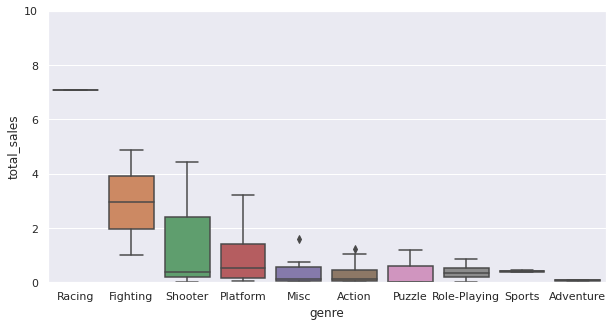

In [57]:
sns.boxplot(x='genre', y='total_sales', data=actual_data.query('platform == "WiiU"'))
plt.ylim(0,10)

У WiiU лучшие медианные продажи у файтингов.

<AxesSubplot:xlabel='genre'>

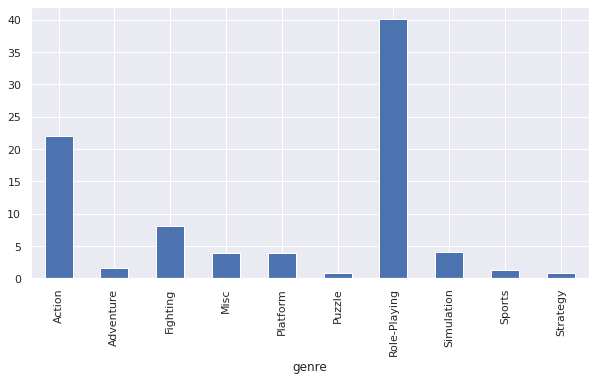

In [58]:
# 3DS
actual_data.query('platform == "3DS"').groupby('genre')['total_sales'].sum().plot(kind='bar')

(0.0, 1.0)

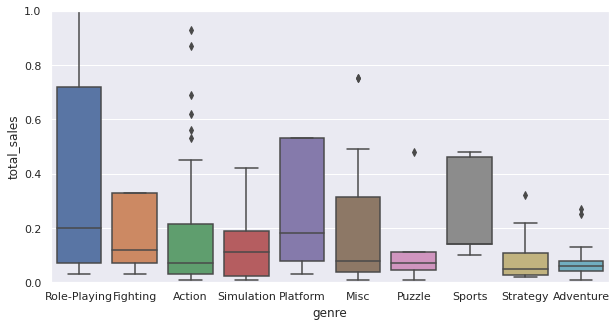

In [59]:
sns.boxplot(x='genre', y='total_sales', data=actual_data.query('platform == "3DS"'))
plt.ylim(0,1)

А на 3DS вперед вырываются ролевые игры.

## Портрет игрока в разных регионах
Нужно выяснить различия предпочтений игроков в разных регионах, чтобы предлагать им более востребованные проекты.

### Топ-5 платформ по регионам

In [60]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,Нет оценки,Нет оценки,Нет рейтинга,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,Нет оценки,Нет оценки,Нет рейтинга,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,Нет оценки,Нет оценки,Нет рейтинга,7.98


In [61]:
# создадим функцию построения диаграммы
def create_pie_diag(subject, region):
    
    '''Функция принимает строку region с кол-вом продаж, например, "na_sales"
    и строит круговую диаграмму для топ-5 объектов датасета - subject, 
    убирая все остальные в категорию Other
    '''
    
    # посчитаем общие продажи в регионе
    all_sales = sum(actual_data[region])
    
    # возьмем топ-5 платформ
    platform_parts = actual_data.groupby(subject)[region].sum().sort_values(ascending=False)[0:5].tolist()
    
    # добавим к списку разность для оставшихся платформ
    platform_parts.append(all_sales - sum(platform_parts))
    
    # именуем группы
    labels = actual_data.groupby(subject)[region].sum().sort_values(ascending=False)[0:5].index.tolist()
    
    # добавим к списку группу Other
    labels.append('Other')
    
    # задаем палитру
    colors = sns.color_palette('pastel')[0:6]

    # строим круговую диаграмму
    print(region)
    plt.pie(platform_parts, labels=labels, colors=colors, autopct='%.0f%%')
    plt.show()

na_sales


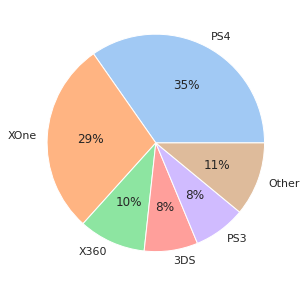

eu_sales


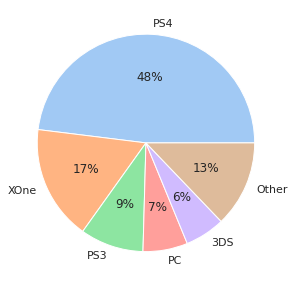

jp_sales


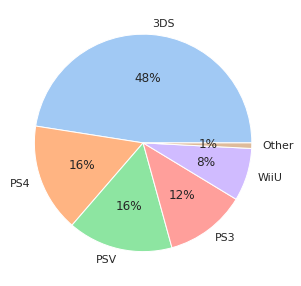

In [62]:
create_pie_diag('platform', 'na_sales')
create_pie_diag('platform', 'eu_sales')
create_pie_diag('platform', 'jp_sales')

**Северная Америка**: 
1. PS4
2. XOne
3. X360
4. 3DS
5. PS3

**Европа**:
1. PS4
2. XOne
3. PS3
4. PC
5. 3DS

**Япония**:
1. 3DS
2. PS4
3. PS3
4. PSV
5. WiiU

PS4 чаще других оказывается в лидерах, а в Японии вперед выходит 3DS, как родная платформа.

### Топ-5 по жанрам

na_sales


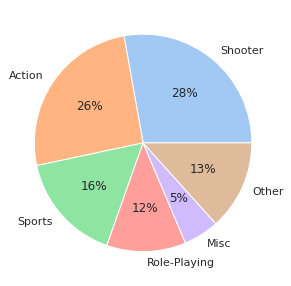

eu_sales


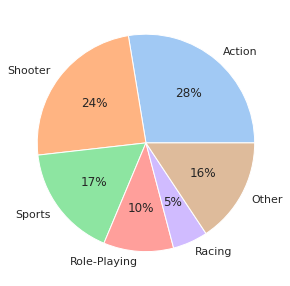

jp_sales


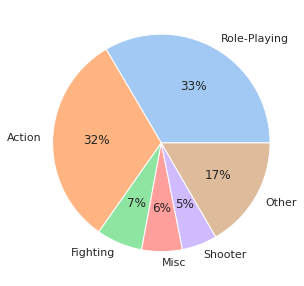

In [63]:
create_pie_diag('genre', 'na_sales')
create_pie_diag('genre', 'eu_sales')
create_pie_diag('genre', 'jp_sales')

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 У нас в задании просят сделать анализ по топ-5. И лучше визуализировать круговой диаграммой, только продажи платформ/жанров не вошедших в топ, собрать в одной группе, например "Другие", и по платформам, и по жанрам. Тогда на круговых диаграммах хорошо видны все региональные рынки игр с разбиением на платформы/жанры. Какая платформа/жанр занимает какую долю рынка. И наша визуализация несет определенную бизнес-логику, связанную именно с долями рынка занимаемыми платформами/жанрами. А этого не дают другие виды диаграмм. Примерно вот так:</font>
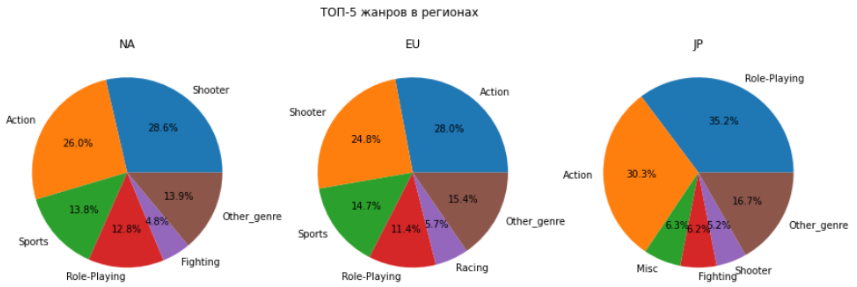

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Изменил.
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Молодец, хорошо решение. 👍</font>

**Северная Америка**: 
1. Шутеры
2. Экшен
3. Спорт
4. Ролевые
5. Внежанровые

**Европа**:
1. Экшен
2. Шутер
3. Спорт
4. Ролевые
5. Гонки

**Япония**:
1. Ролевые
2. Экшен
3. Файтинги
4. Внежанровые
5. Шутеры

В Америке и Европе лидируют игры жанров: экшен, шутер и спорта, а вот в Японии вперед резко вырываются ролевые игры, и даже появляются файтинги. Это может быть связано с громкими хитами в этих жанрах, разрабатываемых в Японии только для местного рынка.

### Влияние рейтинга ESRB на продажи

Проверим, влияет ли как-то рейтинг на продажи игр в отдельном регионе.

In [64]:
# какие есть рейтинги
actual_data['rating'].value_counts()

Нет рейтинга    749
T               271
M               265
E               219
E10+            185
Name: rating, dtype: int64

Придется избавиться от строк с отсутствием рейтинга, так как нам это ни о чем не скажет.

In [65]:
# смотрим, как распределены доли игр разных рейтингов
part = actual_data.groupby('rating')['na_sales'].agg(count='count')
part['part'] = part['count'] / part['count'].sum()
part

,count,part
rating,,
E,219,0.129663
E10+,185,0.109532
M,265,0.156898
T,271,0.160450
Нет рейтинга,749,0.443458


44% игр не имеют рейтинга.

<AxesSubplot:xlabel='rating'>

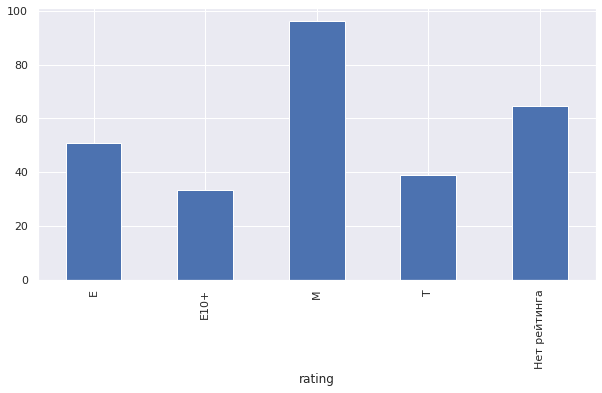

In [66]:
# посмотрим, как распределены продажи в зависимости от рейтинга в Северной Америке
actual_data.groupby('rating')['na_sales'].sum().plot(kind='bar')

<AxesSubplot:xlabel='rating'>

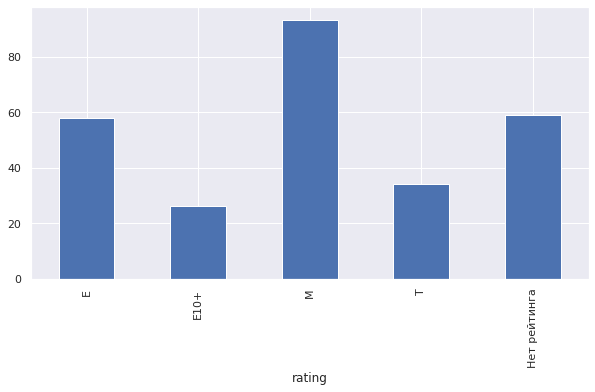

In [67]:
# посмотрим, как распределены продажи в зависимости от рейтинга в Европе
actual_data.groupby('rating')['eu_sales'].sum().plot(kind='bar')

<AxesSubplot:xlabel='rating'>

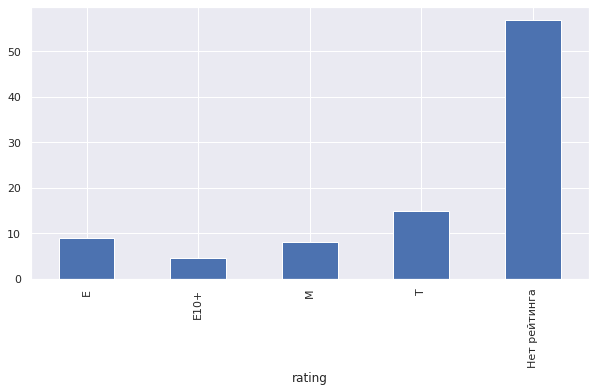

In [68]:
# посмотрим, как распределены продажи в зависимости от рейтинга в Японии
actual_data.groupby('rating')['jp_sales'].sum().plot(kind='bar')

In [69]:
# посмотрим, как менялись продажи в течение трех лет в зависимости от рейтинга в Америке
actual_data.pivot_table(index='rating', columns='year_of_release', values='na_sales', aggfunc='sum')

year_of_release,2014,2015,2016
rating,,,
E,24.15,18.62,7.97
E10+,15.36,14.06,3.81
M,49.39,31.36,15.67
T,16.09,13.91,8.95
Нет рейтинга,27.28,28.91,8.53


In [70]:
# посмотрим, как менялись продажи в течение трех лет в зависимости от рейтинга в Европе
actual_data.pivot_table(index='rating', columns='year_of_release', values='eu_sales', aggfunc='sum')

year_of_release,2014,2015,2016
rating,,,
E,23.23,21.22,13.61
E10+,14.62,7.73,3.81
M,47.90,29.00,16.54
T,13.75,10.53,9.79
Нет рейтинга,23.24,28.24,7.47


In [71]:
# посмотрим, как менялись продажи в течение трех лет в зависимости от рейтинга в Японии
actual_data.pivot_table(index='rating', columns='year_of_release', values='jp_sales', aggfunc='sum')

year_of_release,2014,2015,2016
rating,,,
E,3.69,4.18,1.07
E10+,1.19,2.82,0.45
M,3.72,3.09,1.20
T,7.08,5.43,2.27
Нет рейтинга,24.01,18.57,14.32


По полученным результам нет большой разницы между Америкой и Европой в плане продаж игр в зависимости от рейтинга. Япония сильно отличается, там большинство за играми без рейтинга. Вероятно, потому, что там много игр, которые не покидают внутреннего рынка. Заявлять о зависимости продаж от рейтинга нельзя.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Это пример, когда пропуски в датасете имеют значение. В Японии свой рейтинг и им мало интересны игры с Северо-Американским рейтингом. А есть еще рейтинги ЕС, отдельно в Германии, в Австралии и т.д. Но у нас нет по ним данных и в данном случае пропуск является признаком, что игра имеет другой рейтинг и выпускалась не в Северной Америке.</font>

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Мы при предобработке данных поставили заглушку на пропуски в рейтинге ESRB и это правильно. Но мы ее отфильтровали и игры без рейтинга оказываются полностью исключенными из анализа. Но продажи именно этих игр могут указать на ключевое различие в регионах. По этому необходимо сделать анализ вместе с заглушкой.</font><br>
<font color='DarkMagenta'>👉 А проблема у нас в том, что если посмотреть в инете, что из себя представляет рейтинг ESRB, то окажется, что он предназначен для маркировки игр для США и Канады. И логично, что для других регионов он не заполняется. Наша задача смотреть шире на исходный датасет, так как за цифрами находятся реальные бизнес-процессы. И мы должны это учитывать при предобработке данных.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Посмотрел вместе с категорией без рейтинга. Правда, такие игры продавались везде, включая Америку:) Возможно, игра одновременно может иметь и не иметь рейтинг в зависимости от региона, а датасет такую информацию не содержит.
</div>

## Проверка гипотез

### Равенство средних оценок игроков для Xbox One и PC
**Нулевая гипотеза**: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Альтернативная гипотеза**: средние пользовательские рейтинги платформ Xbox One и PC не равны

Мы используем двустороннюю альтернативную гипотезу, так как нам важно подтвердить или опровергнуть лишь равенство. Уровень статистической значимости возьмем как 5%.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Используется сокращенный датасет, отфильтрованный по заглушкам отзывов критиков.</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Изменил на актуальный.
</div>

In [72]:
# импортируем stats
from scipy import stats as st

# берем две выборки
xbox_score = data_with_user_scores.query('platform == "XOne"')['user_score']
pc_score = data_with_user_scores.query('platform == "PC"')['user_score']

alpha = .05

results = st.ttest_ind(xbox_score, pc_score, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно, что для тестирования гипотез использован двусторонний t-тест.</font>

На самом деле использовать статистику нам не требуется, данных не так много, поэтому лучше будет проверить генеральные совокупности:

In [73]:
print('среднее оценки игроков для Xbox One', data_with_user_scores.query('platform == "XOne"')['user_score'].mean())
print('среднее оценки игроков для PC', data_with_user_scores.query('platform == "PC"')['user_score'].mean())
print('Разница', data_with_user_scores.query('platform == "XOne"')['user_score'].mean() - \
      data_with_user_scores.query('platform == "PC"')['user_score'].mean())

среднее оценки игроков для Xbox One 6.594545454545456
среднее оценки игроков для PC 6.298360655737705
Разница 0.29618479880775084


Формально можно считать, что средние оценки равны, если отбросить дробную часть.

### Неравенство оценок игроков для двух жанров

**Нулевая гипотеза**: средние оценки игроков для жанров Action и Sports равны друг другу.

**Альтернативная гипотеза**: средние оценки игроков для жанров Action и Sports не равны.

Здесь тоже подойдет двусторонняя альтернативная гипотеза, так как нам важно опровергнуть равенство. Уровень статистической значимости возьмем как 5%.

In [74]:
# берем две выборки
action_score = data_with_user_scores.query('genre == "Action"')['user_score']
sports_score = data_with_user_scores.query('genre == "Sports"')['user_score']

alpha = .05

results = st.ttest_ind(action_score, sports_score, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Лучше было написать, что на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.</font>

Здесь нам тоже на самом деле не нужно применять статистику.

In [75]:
action_score_general = data_with_user_scores.query('genre == "Action"')['user_score'].mean()
sports_score_general = data_with_user_scores.query('genre == "Sports"')['user_score'].mean()
print(f'Средние для экшена: {action_score_general}.\nСредние для спортивных игр: {sports_score_general}')
if action_score_general == sports_score_general:
    print('Средние арифметически равны')
    print('Разница', action_score_general - sports_score_general)
else:
    print('Средние арифметически неравны')
    print('Разница', action_score_general - sports_score_general)

Средние для экшена: 6.760606060606061.
Средние для спортивных игр: 5.2251968503937
Средние арифметически неравны
Разница 1.5354092102123609


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно, что показаны дополнительно средние пользовательские рейтинги и по платформам, и по жанрам, как иллюстрации не противоречивости наших гипотез.</font><br>
<font color='Red'>🛠 Необходимо сделать выводы по данному разделу согласно заданию:<br>
<b>Поясните:<br>
Как вы сформулировали нулевую и альтернативную гипотезы;<br>
Какой критерий применили для проверки гипотез и почему.</b>
</font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Дополнил.
</div>

Гипотезы формулировались, исходя из задания. В обоих случаях речь шла о проверке равенства или неравенства, нулевая гипотеза бралась как равенство, так как есть тест на равенство выборок генеральных совокупностей. Соответственно, альтернативная гипотеза бралась противопложная. Критерием проверки гипотез являлось среднее выборки, которое должно было попасть в зону нормального распределения как можно ближе к истинному среднему, не далее 2,5% с каждой стороны (не было важно, в какую сторону упадет). Также были проверены истинные средние генеральных совокупностей, так как их вполне можно обработать без t-теста.

## Вывод

В ходе данного исследования мы проанализировали игры на самых популярных платформах, начиная с 2014 года, чтобы понять, какие игры нужно будет закупать в 2017 году.
1. Мы подготовили данные, избавились от пропусков, изменили типы данных, а также избавились от большей части данных. Информация с 1980 года для нашего исследования не имеет ценности, так как большинство платформ больше не выпускается, а игры для них делать точно не будут. Для детального анализа взяты три платформы: **PC**, **PS4**, **XOne**, а в общем к ним добавилось уходящее поколение: **PS3**, **WiiU**, **3DS**, **X360**. На последние платформы игры выходить могут, но очевидно, что их будет становиться меньше, и основной упор нужно делать на новое поколение устройств.
2. У **PC**, **PS4**, **XOne** за последний года наблюдается одна и та же картина: продажи игр резко **уменьшаются**, но количество новых проектов постоянно **растет**. Пока нет оснований предполагать, что спад достигнет критических значений, а новая продукция не будет появляться для продажи. Возможно увеличение сроков производства игр, так как оно становится технологически сложнее.
3. **PS4** в большинстве случаев показывает лучшие результаты на разных рынках, поэтому игры на эту платформу стоит рассматривать в приоритете.
4. **Оценки критиков** имеют слабую положительную корреляцию с уровнем продаж, после **60 баллов** у многих проектов наблюдается рост продаж. А вот **оценки игроков** выраженной корреляции не имеют, поэтому их использовать для прогнозов не получится.
5. В приоритете стоит рассматривать игры в жанрах: **Action**, **Sports**, **Shooter** для западного рынка, а также **Role-Playing** для азиатского. Для ПК-игроков нужно обратить внимание на **Simulation**, **Strategy**.
6. Портрет игрока в разных регионах таков:

| **Америка**           | **Европа**            | **Япония**          |
| :-------------------: | :-------------------: |:-------------------:|
|                       |                       |                     |                
| **Топ-3 устройств**:  | **Топ-3 устройств**:  | **Топ-3 устройств**:|                
| 1. PS4                | 1. PS4                | 1. 3DS              |
| 2. XOne               | 2. XOne               | 2. PS4              |
| 3. X360               | 3. PS3                | 3. PS3              |
| **Топ-3 жанров**:     | **Топ-3 жанров**:     | **Топ-3 жанров**:   |
| 1. Шутеры             | 1. Экшен              | 1. Ролевые          |
| 2. Экшен              | 2. Шутер              | 2. Экшен            |
| 3. Спорт              | 3. Спорт              | 3. Файтинги         |

7. Выявить зависимость рейтинга ESRB на кол-во продаж не удалось, ориентироваться на это не стоит.
8. Дополнительно проверили две гипотезы статистическим и обычным методом о том, что средние оценки игроков на **XOne** и **PC** равны и для жанров **Action** и **Sport** не равны. Опровегнуть первую гипотезу о равенстве не удалось, а вторую получилось. Средние оценки пользователей двух разных платформ действительно получились очень близкими, а вот в зависимости от жанров отличались куда сильнее.

**Итого**:
- в качестве приоритетных платформ стоит рассмотреть **PS4** и **XOne**, как представителей актуального поколения устройств, а среди портативных устройств — **WiiU**, **3DS**.
- Среди жанров упор нужно сделать на **Shooter**,  **Sports** и **Action** игры. Для Японии также нужно брать **Role-Playing**, именно для **PC** стоит рассмотреть **Simulation**.
- На оценки прессы и критиков можно ориентироваться, беря игры выше 60 баллов, а вот на пользовательские оценки полагаться не стоит.
- Рейтинг ESRB важного влияния оказывать не будет, но если говорить именно Северной Америке, то стоит сначала обращать внимание на игры с рейтингом **M**.


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Цель нашего исследования понять, на что потратить рекламный бюджет. В исследовании мы проанализировали игры с разных сторон. Логично, что рекламный отдел от нас ждет на какие платформы (1-2 штуки, на большее у нас не хватит рекламного бюджета), с каким жанром, с каким рейтингом ESRB и в каком регионе рекламировать. Стоит ли обращать внимание на отзывы или нет.<br>У нас вся информация в проекте уже есть, надо просто акцентировать на какие игры тратить рекламный бюджет. Сделаем?</font><br>
<font color='DarkMagenta'>👉 Возможно, придется переделать часть выводов после исправления ошибок. </font>

<div class="alert alert-info"> 
<b>Комментарий студента 1</b> 
    
Дополнил вывод.
</div>

<font color='DarkBlue'><b>Заключительный комментарий ревьюера</b></font><br><br>
<font color='DarkGreen'>👌 Марат, проект отлично структурирован и проработан.<br>Так держать и дальше!<br></font>
<font color='Red'>🛠 Что нам нужно, что бы сделать проект лучше:</font><br>
<font color='Red'>🛠 Определить актуальный период без фильтрации по платформам. Построить диаграммы размаха по глобальным продажам игр в разбивке по всем платформам. Раздельно отфильтровать заглушки при анализе отзывов. Анализ влияния отзывов на продажи надо провести по нескольким платформам. В анализе игр по жанрам надо проанализировать медианные значения продаж, построив диаграммы размаха. Переделать анализ влияния рейтинга ESRB на продажи в регионах. Переделать раздел проверки гипотез.</font><br>
<font color='DarkMagenta'>👉 При исправлении ошибок и недочетов мы приобретем дополнительный опыт и навыки!</font><br>
<font color='DarkGreen'>👌 Жду окончательный вариант! Успехов.</font>

<font color='DarkBlue'><b>Заключительный комментарий ревьюера 2</b></font><br><br>
<font color='DarkGreen'>👌 Марат! Нам удалось справиться со всеми подводными камнями в проекте.  Мы молодцы! 😄<br>
Мы узнали, что не все пропуски просто ошибки сбора данных, а несут свои признаки. Для этого нам понадобилось за данными датасета увидеть смысл этих данных и бизнес-процессы, которые за ними скрываются. Мы узнали, что медианы могут дать дополнительную информацию при анализе. Это наши новые знания и навыки, которые нам пригодятся в будущем!<br></font>
<font color='DarkGreen'>👌 Теперь, вперед за новыми знаниями и навыками! Удачи! 😉</font>
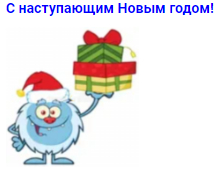